<a href="https://colab.research.google.com/github/anantp316/Stackoverflow-QA---Classification-Problem/blob/main/Stackoverflow_QA_Classification_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement 

## This is a dataset containing 60,000 Stack Overflow questions from 2016-2020. Questions are classified into three categories:

* HQ: High-quality posts without a single edit.
* LQ_EDIT: Low-quality posts with a negative score, and multiple community edits. However, they still remain open after those changes.
* LQ_CLOSE: Low-quality posts that were closed by the community without a single edit.

## **Aim** - To build a classifier model on training data(train.csv) and validate its performance on validation data(valid.csv)

# Loading the data from Kaggle

You may need to use the Kaggle API token to load data into Google Colab environment.

**Note** - This is only for Google Colab users.

In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [8]:
!kaggle datasets download imoore/60k-stack-overflow-questions-with-quality-rate

 81% 17.0M/21.0M [00:00<00:00, 85.1MB/s]
100% 21.0M/21.0M [00:00<00:00, 84.3MB/s]


In [9]:
!unzip *.zip

Archive:  60k-stack-overflow-questions-with-quality-rate.zip
  inflating: train.csv               
  inflating: valid.csv               


# Importing Libraries

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import random


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import sklearn.metrics

import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff

# Data Preparation

In [2]:
df_train = pd.read_csv("/content/train.csv")
df_train.head()

,Id,Title,Body,Tags,CreationDate,Y
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE
1,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ
2,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ
3,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ
4,34553755,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,HQ


In [3]:
df_train.count()

Id              45000
Title           45000
Body            45000
Tags            45000
CreationDate    45000
Y               45000
dtype: int64

Checking for nulls in training dataset.

In [4]:
df_train.isna().sum().sum()

0

In [5]:
df_val = pd.read_csv("/content/valid.csv")
df_val.head()

,Id,Title,Body,Tags,CreationDate,Y
0,34552974,How to get all the child records from differen...,I am having 4 different tables like \r\nselect...,<sql><sql-server>,2016-01-01 01:44:52,LQ_EDIT
1,34554721,Retrieve all except some data of the another t...,I have two table m_master and tbl_appointment\...,<php><mysql><sql><codeigniter><mysqli>,2016-01-01 08:43:50,LQ_EDIT
2,34555135,Pandas: read_html,<p>I'm trying to extract US states from wiki U...,<python><pandas>,2016-01-01 09:55:22,HQ
3,34555448,Reader Always gimme NULL,"I'm so new to C#, I wanna make an application ...",<sql-server><c#-4.0>,2016-01-01 10:43:45,LQ_EDIT
4,34555752,php rearrange array elements based on condition,basically i have this array:\r\n\r\n array(...,<php>,2016-01-01 11:34:09,LQ_EDIT


In [6]:
df_val.count()

Id              15000
Title           15000
Body            15000
Tags            15000
CreationDate    15000
Y               15000
dtype: int64

Checking for nulls in validation dataset.


In [7]:
df_val.isna().sum().sum()

0

# Data Preprocessing

## Dropping ID, Tags and CreationDate.

### At the moment we shall only focus on text and its category("Y") we can reserve Tags and CreationDate for another way to re-visit this problem.

In [8]:
df_train = df_train.drop(['Id', 'Tags', 'CreationDate'], axis=1)
df_train['Y'] = df_train['Y'].map({'LQ_CLOSE':0, 'LQ_EDIT': 1, 'HQ':2})
df_train.head()

,Title,Body,Y
0,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,0
1,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,2
2,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,2
3,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",2
4,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,2


In [9]:
df_val = df_val.drop(['Id', 'Tags', 'CreationDate'], axis=1)
df_val['Y'] = df_val['Y'].map({'LQ_CLOSE':0, 'LQ_EDIT': 1, 'HQ':2})
df_val.head()

,Title,Body,Y
0,How to get all the child records from differen...,I am having 4 different tables like \r\nselect...,1
1,Retrieve all except some data of the another t...,I have two table m_master and tbl_appointment\...,1
2,Pandas: read_html,<p>I'm trying to extract US states from wiki U...,2
3,Reader Always gimme NULL,"I'm so new to C#, I wanna make an application ...",1
4,php rearrange array elements based on condition,basically i have this array:\r\n\r\n array(...,1


### We join the title and the body of the provided text data to leverage both during classification process.

In [10]:
df_train['concat_text'] = df_train['Title'] + ' ' + df_train['Body']
df_train = df_train.drop(['Title', 'Body'], axis=1)
df_train.head()

,Y,concat_text
0,0,Java: Repeat Task Every Random Seconds <p>I'm ...
1,2,Why are Java Optionals immutable? <p>I'd like ...
2,2,Text Overlay Image with Darkened Opacity React...
3,2,Why ternary operator in swift is so picky? <p>...
4,2,hide/show fab with scale animation <p>I'm usin...


In [11]:
df_val['concat_text'] = df_val['Title'] + ' ' + df_val['Body']
df_val = df_val.drop(['Title', 'Body'], axis=1)
df_val.head()

,Y,concat_text
0,1,How to get all the child records from differen...
1,1,Retrieve all except some data of the another t...
2,2,Pandas: read_html <p>I'm trying to extract US ...
3,1,"Reader Always gimme NULL I'm so new to C#, I w..."
4,1,php rearrange array elements based on conditio...


## Defining a custom text cleaning function

### This function does the following - 


*   Standardizes text by lowercasing all of it.
*   Uses regex to get rid of tags, special characters, etc.



In [12]:
def cleanse(concat_text):
    concat_text = concat_text.lower()
    concat_text = re.sub(r'[^(a-zA-Z)\s]','', concat_text)
    return concat_text

In [13]:
df_train['cleaned_text'] = df_train['concat_text'].apply(cleanse)

In [14]:
df_val['cleaned_text'] = df_val['concat_text'].apply(cleanse)

## Shuffles dataframe


In [15]:
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_val = df_val.sample(frac=1).reset_index(drop=True)

## Assigning X and Y values

### For both training and validation datasets - 

*   X Variable - Cleaned text
*   Y Variable - Y



In [16]:
X_train = df_train['cleaned_text']
Y_train = df_train['Y'].values

In [17]:
X_val = df_val['cleaned_text']
Y_val = df_val['Y'].values

## Vectorization of data

### Vectorizer : TF-IDF Vectorizer 

TF-IDF stands for “Term Frequency — Inverse Document Frequency”. This is a technique to quantify words in a set of documents. We generally compute a score for each word to signify its importance in the document and corpus. 


We load the TF-IDF vectorizer, first we fit it on training dataset and then transform it on validation dataset.

In [18]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_val = vectorizer.transform(X_val)

## Checking sizes of training and validation datasets

In [19]:
print("Shape of training dataset size :",df_train.shape)
print("Shape of validation dataset size :",df_val.shape)

Shape of training dataset size : (45000, 3)
Shape of validation dataset size : (15000, 3)


# ML Modelling

We approach the problem by building ML Models from simple to complex models on training set and then assess them on the basis of their scores on validation dataset.

## Multinomial Naive Bayes

In [20]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, Y_train)

MultinomialNB()

In [21]:
nb_val_accuracy = nb_classifier.score(X_val, Y_val)
print(f"Validation Accuracy of Naive Bayes Classifier is: {(nb_val_accuracy)*100:.2f}%")

Validation Accuracy of Naive Bayes Classifier is: 78.73%


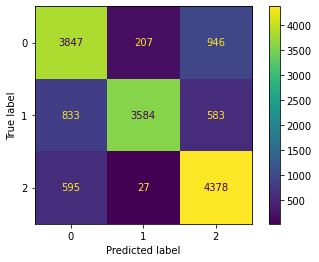

In [22]:
sklearn.metrics.ConfusionMatrixDisplay.from_estimator(nb_classifier, X_val, Y_val)

## Logistic Regression

In [23]:
lr_classifier = LogisticRegression(C=1.)
lr_classifier.fit(X_train, Y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression()

In [24]:
lr_val_accuracy = lr_classifier.score(X_val, Y_val)
print(f"Validation Accuracy of Logisitic Regression Classifier is: {(lr_val_accuracy )*100:.2f}%")

Validation Accuracy of Logisitic Regression Classifier is: 87.51%


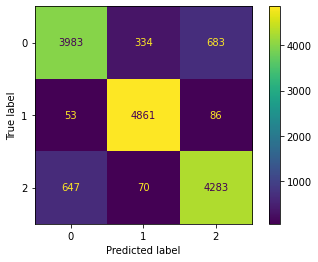

In [25]:
sklearn.metrics.ConfusionMatrixDisplay.from_estimator(lr_classifier, X_val, Y_val)

## KNN Classifier

In [26]:
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train, Y_train)

KNeighborsClassifier()

In [27]:
knn_val_accuracy = knn_classifier.score(X_val, Y_val)
print(f"Validation Accuracy of KNN Clf. is: {(knn_val_accuracy)*100:.2f}%")

Validation Accuracy of KNN Clf. is: 56.49%


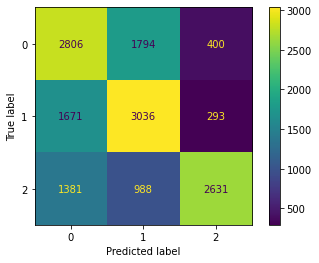

In [28]:
sklearn.metrics.ConfusionMatrixDisplay.from_estimator(knn_classifier, X_val, Y_val)

## Support Vector Classifier

In [29]:
#svc_classifier = SVC(kernel = 'linear')
#svc_classifier.fit(X_train, Y_train)

In [30]:
#print(f"Validation Accuracy of Support Vector Classifier is: {(svc_classifier.score(X_val, Y_val))*100:.2f}%")

In [31]:
#sklearn.metrics.ConfusionMatrixDisplay.from_estimator(svc_classifier, X_val, Y_val)

## Decision Tree Classifier

In [32]:
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train, Y_train)

DecisionTreeClassifier()

In [33]:
dt_val_accuracy = dt_classifier.score(X_val, Y_val)
print(f"Validation Accuracy of Decision Tree Clf. is: {(dt_val_accuracy)*100:.2f}%")

Validation Accuracy of Decision Tree Clf. is: 78.90%


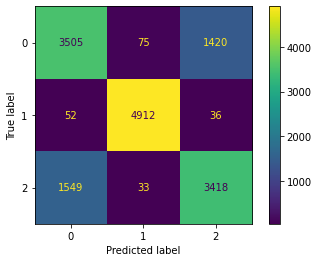

In [34]:
sklearn.metrics.ConfusionMatrixDisplay.from_estimator(dt_classifier, X_val, Y_val)

## Random Forest Classifier

In [35]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, Y_train)

RandomForestClassifier()

In [36]:
rf_val_accuracy = rf_classifier.score(X_val, Y_val)
print(f"Validation Accuracy of Random Forest Classifier is: {(rf_val_accuracy)*100:.2f}%")

Validation Accuracy of Random Forest Classifier is: 83.16%


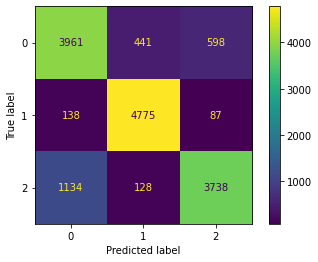

In [37]:
sklearn.metrics.ConfusionMatrixDisplay.from_estimator(rf_classifier, X_val, Y_val)

## MLP Classifier

In [38]:
mlp_classifier = MLPClassifier()
mlp_classifier.fit(X_train, Y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: UserWarning:

Training interrupted by user.



MLPClassifier()

In [39]:
mlp_val_accuracy = mlp_classifier.score(X_val, Y_val)
print(f"Validation Accuracy of MLP Classifier is: {(mlp_val_accuracy)*100:.2f}%")

Validation Accuracy of MLP Classifier is: 86.11%


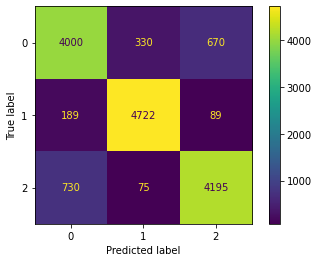

In [40]:
sklearn.metrics.ConfusionMatrixDisplay.from_estimator(mlp_classifier, X_val, Y_val)

# Scoring ML Model Performance

## List of Validation Accuracies

In [52]:
print(f"Validation Accuracy of Naive Bayes Classifier is: {(nb_val_accuracy)*100:.2f}%")
print(f"Validation Accuracy of Logisitic Regression is: {(lr_val_accuracy )*100:.2f}%")
print(f"Validation Accuracy of KNN Clf. is: {(knn_val_accuracy)*100:.2f}%")
print(f"Validation Accuracy of Decision Tree Clf. is: {(dt_val_accuracy)*100:.2f}%")
print(f"Validation Accuracy of Random Forest Classifier is: {(rf_val_accuracy)*100:.2f}%")
print(f"Validation Accuracy of MLP Classifier is: {(mlp_val_accuracy)*100:.2f}%")

Validation Accuracy of Naive Bayes Classifier is: 78.73%
Validation Accuracy of Logisitic Regression is: 87.51%
Validation Accuracy of KNN Clf. is: 56.49%
Validation Accuracy of Decision Tree Clf. is: 78.90%
Validation Accuracy of Random Forest Classifier is: 83.16%
Validation Accuracy of MLP Classifier is: 86.11%


# Conclusion

The following models performed the best - 


1.   Logistic Regression - 87.51%
2.   MLP Classifier - 86.11%
3.   Random Forest Classifier - 83.16%




# Future Scope



*   Hyper-parameter optimization on top 3 models to further better the performance.
*   Make use of dropped CreationDate and Tags columns to create another approach.


